In [0]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy.signal import convolve, convolve2d
import os
import shutil
import re
from tqdm import tqdm
from PIL import Image
from skimage.color import rgb2gray, gray2rgb
from sklearn.model_selection import train_test_split
import tensorflow as tf
# Keras Libraries
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import Flatten, Dense, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16
import h5py
from sklearn import metrics
from sklearn.utils import shuffle, class_weight


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def extract_images_c(task, dataset = 'original'):
  # task = 1 : normal vs pneumonia
  # task = 2 : bacterial vs viral 
    if task == 1:
        with h5py.File('/content/drive/My Drive/project/dataset_new/task1_' + dataset + '.h5', 'r') as hf:
            x_train, y_train, x_test, y_test = hf['x_train'][:], hf['y_train'][:, 0], hf['x_test'][:], hf['y_test'][:, 0]
            
    else:
        with h5py.File('/content/drive/My Drive/project/dataset_new/task2_' + dataset + '.h5', 'r') as hf:
            x_train, y_train, x_test, y_test = hf['x_train'][:], hf['y_train'][:, 0], hf['x_test'][:], hf['y_test'][:, 0]
    return (x_train, y_train, x_test, y_test) 

In [0]:
#VGG16
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = model.output
x = Flatten()(x)
#x = Dense(4096, activation = 'relu')(x)
#x = Dense(1024, activation = 'relu')(x)
x = Dense(1, activation = 'sigmoid')(x)
vgg = Model(inputs = model.input, outputs = x)

In [0]:
for layer in vgg.layers[0:20]:
    layer.trainable = False

In [6]:
vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
x_train, y_train, x_test, y_test = extract_images_c(1, 'original')
cw = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
cw = {0 : cw[0], 1 : cw[1] / 1.1}
x_train = np.repeat(x_train[..., np.newaxis], 3, -1)
x_test = np.repeat(x_test[..., np.newaxis], 3, -1)
x_train, y_train = shuffle(x_train, y_train)
#optimizer = Adam(lr = 1e-5)
optimizer = RMSprop(lr = 1e-5)
vgg.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=optimizer)
history_o = vgg.fit(x_train, y_train, 
                    class_weight = cw,
                    epochs = 10,
                    batch_size = 32,
                    validation_data = (x_test, y_test))

Epoch 1/10
155/155 [==============================] - 15s 97ms/step - loss: 0.5630 - accuracy: 0.7282 - val_loss: 0.5743 - val_accuracy: 0.8045
Epoch 2/10
155/155 [==============================] - 14s 89ms/step - loss: 0.4319 - accuracy: 0.8784 - val_loss: 0.4705 - val_accuracy: 0.8638
Epoch 3/10
155/155 [==============================] - 14s 90ms/step - loss: 0.3449 - accuracy: 0.9008 - val_loss: 0.4090 - val_accuracy: 0.8574
Epoch 4/10
155/155 [==============================] - 14s 90ms/step - loss: 0.2872 - accuracy: 0.9097 - val_loss: 0.3701 - val_accuracy: 0.8606
Epoch 5/10
155/155 [==============================] - 14s 90ms/step - loss: 0.2478 - accuracy: 0.9206 - val_loss: 0.3466 - val_accuracy: 0.8670
Epoch 6/10
155/155 [==============================] - 14s 90ms/step - loss: 0.2203 - accuracy: 0.9256 - val_loss: 0.3295 - val_accuracy: 0.8702
Epoch 7/10
155/155 [==============================] - 14s 90ms/step - loss: 0.1999 - accuracy: 0.9309 - val_loss: 0.3230 - val_accuracy:

In [0]:
pred_o_train = vgg.predict(x_train)
label_o_train = y_train
pred_o_test = vgg.predict(x_test)
label_o_test = y_test
spec_o_train, sens_o_train, _ = metrics.roc_curve(label_o_train, pred_o_train)
spec_o_test, sens_o_test, _ = metrics.roc_curve(label_o_test, pred_o_test)

In [9]:
auc = metrics.roc_auc_score(y_test, vgg.predict(x_test))
auc

0.9543611658996274

In [10]:
#VGG16
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = model.output
x = Flatten()(x)
#x = Dense(4096, activation = 'relu')(x)
#x = Dense(1024, activation = 'relu')(x)
x = Dense(1, activation = 'sigmoid')(x)
vgg = Model(inputs = model.input, outputs = x)
for layer in vgg.layers[0:20]:
    layer.trainable = False
# split train and test    
x_train, y_train, x_test, y_test = extract_images_c(1, 'blurred')
cw = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
cw = {0 : cw[0], 1 : cw[1] / 1.1}
x_train = np.repeat(x_train[..., np.newaxis], 3, -1)
x_test = np.repeat(x_test[..., np.newaxis], 3, -1)
x_train, y_train = shuffle(x_train, y_train)
#optimizer = Adam(lr = 1e-4)
optimizer = RMSprop(lr = 1e-5)
vgg.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=optimizer)
history_b = vgg.fit(x_train, y_train, 
                    class_weight = cw,
                    epochs = 10,
                    batch_size = 32,
                    validation_data = (x_test, y_test))

Epoch 1/10
155/155 [==============================] - 14s 92ms/step - loss: 0.5585 - accuracy: 0.8068 - val_loss: 0.5533 - val_accuracy: 0.8381
Epoch 2/10
155/155 [==============================] - 14s 91ms/step - loss: 0.4325 - accuracy: 0.8729 - val_loss: 0.4694 - val_accuracy: 0.8446
Epoch 3/10
155/155 [==============================] - 14s 92ms/step - loss: 0.3502 - accuracy: 0.8905 - val_loss: 0.4178 - val_accuracy: 0.8542
Epoch 4/10
155/155 [==============================] - 14s 91ms/step - loss: 0.2961 - accuracy: 0.8998 - val_loss: 0.3826 - val_accuracy: 0.8510
Epoch 5/10
155/155 [==============================] - 14s 90ms/step - loss: 0.2610 - accuracy: 0.9093 - val_loss: 0.3600 - val_accuracy: 0.8574
Epoch 6/10
155/155 [==============================] - 14s 91ms/step - loss: 0.2349 - accuracy: 0.9143 - val_loss: 0.3497 - val_accuracy: 0.8542
Epoch 7/10
155/155 [==============================] - 14s 91ms/step - loss: 0.2150 - accuracy: 0.9192 - val_loss: 0.3421 - val_accuracy:

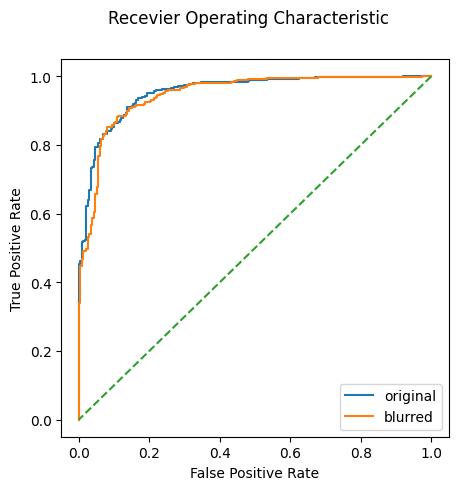

In [11]:
pred_b_train = vgg.predict(x_train)
label_b_train = y_train
spec_b_train, sens_b_train, _ = metrics.roc_curve(label_b_train, pred_b_train)
pred_b_test = vgg.predict(x_test)
label_b_test = y_test
spec_b_test, sens_b_test, _ = metrics.roc_curve(label_b_test, pred_b_test)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 5, 5
fig, ax = plt.subplots(1, 1)
ax.plot(spec_o_test, sens_o_test, label = 'original')
ax.plot(spec_b_test, sens_b_test, label = 'blurred')
ax.plot([1, 0],[1, 0], linestyle = "--")
ax.legend()
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
plt.suptitle('Recevier Operating Characteristic')
plt.savefig('/content/drive/My Drive/ROC_1', dpi = 500)
plt.show()


In [12]:
auc = metrics.roc_auc_score(y_test, vgg.predict(x_test))
auc

0.9467346044269122

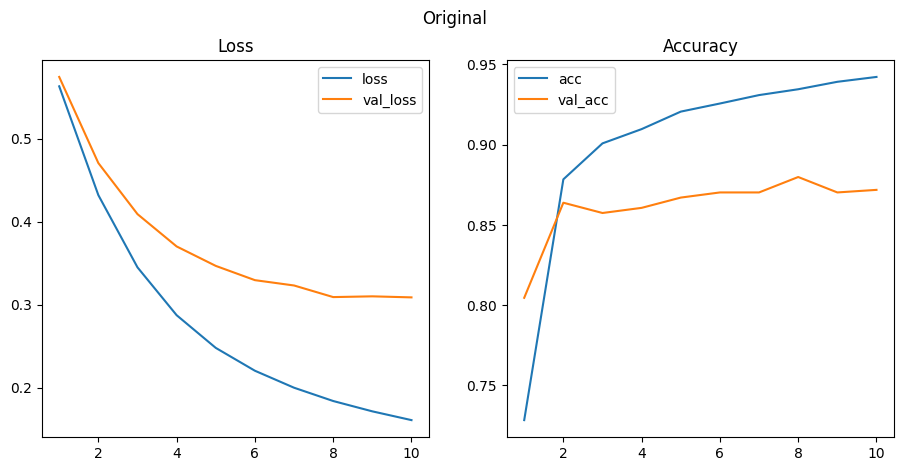

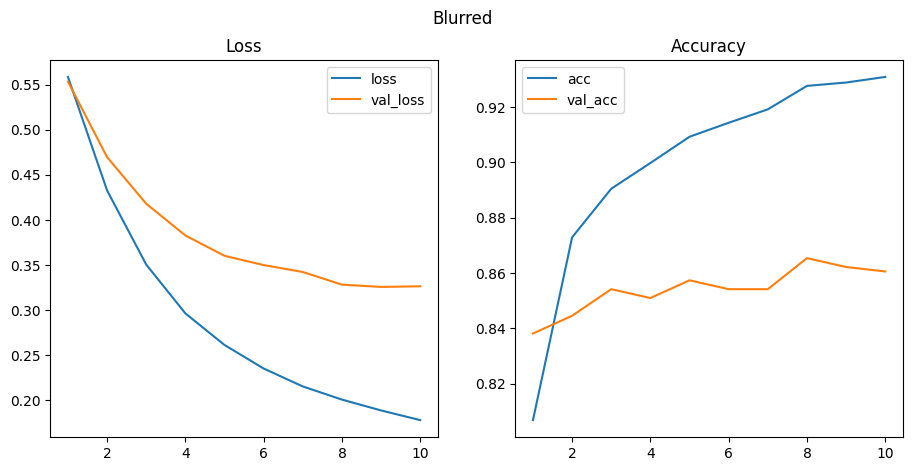

In [13]:
plt.rcParams['figure.figsize'] = 11, 5
fig, ax = plt.subplots(1, 2)
ax[0].plot(np.arange(1, 11), history_o.history['loss'], label = 'loss')
ax[0].plot(np.arange(1, 11), history_o.history['val_loss'], label = 'val_loss')
ax[0].legend()
ax[0].set_title('Loss')
ax[1].plot(np.arange(1, 11), history_o.history['accuracy'], label = 'acc')
ax[1].plot(np.arange(1, 11), history_o.history['val_accuracy'], label = 'val_acc')
ax[1].legend()
ax[1].set_title('Accuracy')
plt.suptitle('Original')
plt.savefig('/content/drive/My Drive/Loss_1_o', dpi = 500)
fig, ax = plt.subplots(1, 2)
ax[0].plot(np.arange(1, 11), history_b.history['loss'], label = 'loss')
ax[0].plot(np.arange(1, 11), history_b.history['val_loss'], label = 'val_loss')
ax[0].legend()
ax[0].set_title('Loss')
ax[1].plot(np.arange(1, 11), history_b.history['accuracy'], label = 'acc')
ax[1].plot(np.arange(1, 11), history_b.history['val_accuracy'], label = 'val_acc')
ax[1].legend()
ax[1].set_title('Accuracy')
plt.suptitle('Blurred')
plt.savefig('/content/drive/My Drive/Loss_1_b', dpi = 500)
plt.show()